## Tests the code for circuits with empty moments

Working of the previous code (cirq.contrib.svg.svg) is shown as follows:

In [17]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

In [18]:
import pytest
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit

A sample circuit is shown as follows along with its ASCII diagram representation and SVG representation:

0: ───@───────×───Z──────────────────M('z')───
      │       │                      │
1: ───X───@───┼──────────────────────M────────
          │   │                      │
2: ───────@───×───PhX(0.456)^0.123───M────────


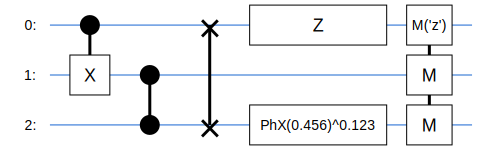

In [19]:
a, b, c = cirq.LineQubit.range(3)
circuit1=cirq.Circuit()
circuit1.append(cirq.Moment(cirq.CNOT(a, b)))
circuit1.append(cirq.Moment(cirq.CZ(b, c)))
circuit1.append(cirq.Moment(cirq.SWAP(a, c)))
circuit1.append(cirq.Moment(cirq.PhasedXPowGate(exponent=0.123, phase_exponent=0.456).on(c)))
circuit1.append(cirq.Z(a))
circuit1.append(cirq.Moment(cirq.measure(a, b, c, key='z')))
print(circuit1)
SVGCircuit(circuit1)

Modifying the circuit slightly by adding an empty moment in between, we see the following ASCII circuit diagram: 

In [20]:
a, b, c = cirq.LineQubit.range(3)
circuit2=cirq.Circuit()
circuit2.append(cirq.Moment(cirq.CNOT(a, b)))
circuit2.append(cirq.Moment(cirq.CZ(b, c)))
circuit2.append(cirq.Moment()) # Empty moment included in the circuit
circuit2.append(cirq.Moment(cirq.SWAP(a, c)))
circuit2.append(cirq.Moment(cirq.PhasedXPowGate(exponent=0.123, phase_exponent=0.456).on(c)))
circuit2.append(cirq.Z(a))
circuit2.append(cirq.Moment(cirq.measure(a, b, c, key='z')))
print(circuit2)

0: ───@───────────×───Z──────────────────M('z')───
      │           │                      │
1: ───X───@───────┼──────────────────────M────────
          │       │                      │
2: ───────@───────×───PhX(0.456)^0.123───M────────


The ASCII diagram shown above takes into account the empty moment by displaying some space between the second and the third moment:
```
0: ───@───────────×───Z──────────────────M('z')───
      │           │                      │
1: ───X───@───────┼──────────────────────M────────
          │       │                      │
2: ───────@───────×───PhX(0.456)^0.123───M────────
            └───┘
      Empty moment shown by spacing
```

Circuit._repr_svg_ doesnt take into account empty moments and generates a value error as shown below:

In [21]:
SVGCircuit(circuit2)

ValueError: Can't draw SVG diagram for circuits with empty moments. Run it through cirq.DropEmptyMoments()

The code generates a value error in the function **_validate_circuit(self.circuit)** itself.

## Bug fix:
On further analysis of svg.py, by bypassing the validation phase for circuits with empty moments, the function tdd_to_svg(tdd) was modified to add spacing in the svg for empty moments

The following code sample shows that

In [22]:
from svg import SVGCircuit # importted from the modified svg.py

In [23]:
print("Circuit without empty moment:")
print(circuit1)
print("\n\n")
print("Circuit without empty moment:")
print(circuit2)

Circuit without empty moment:
0: ───@───────×───Z──────────────────M('z')───
      │       │                      │
1: ───X───@───┼──────────────────────M────────
          │   │                      │
2: ───────@───×───PhX(0.456)^0.123───M────────



Circuit without empty moment:
0: ───@───────────×───Z──────────────────M('z')───
      │           │                      │
1: ───X───@───────┼──────────────────────M────────
          │       │                      │
2: ───────@───────×───PhX(0.456)^0.123───M────────


Circuit without empty moment:


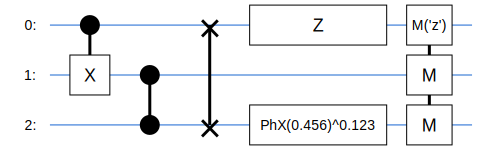

In [24]:
print("Circuit without empty moment:")
SVGCircuit(circuit1)


Circuit with empty moment:


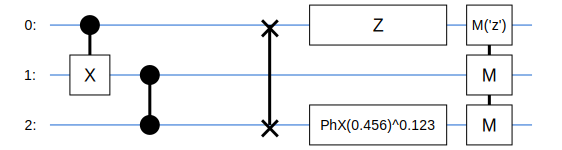

In [25]:
print("Circuit with empty moment:")
SVGCircuit(circuit2)

## Other circuit examples are shown as with the corresponding ASCII representation and SVG representation.


### 1. Circuits with only empty moments:

In [26]:
circuit3=cirq.Circuit()
circuit3.append([
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment()
])
print(circuit3) # notice that no ASCII diagram is being printed

In [27]:
SVGCircuit(circuit3) # generates a blank SVG in such a case

### 2. Circuits starting with 1 or more empty moments

0: ───────────────────@───
                      │
1: ───────────────────X───


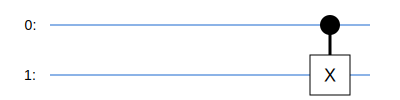

In [28]:
circuit3.append(cirq.Moment(cirq.CNOT(a,b)))
print(circuit3)
SVGCircuit(circuit3)    

### 3. Circuits starting with 1 or more empty moments

0: ───────────────────@───────
                      │
1: ───────────────────X───────


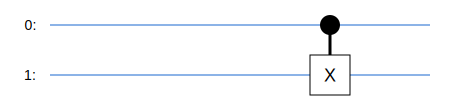

In [29]:
circuit3.append(cirq.Moment())
print(circuit3)
SVGCircuit(circuit3)

### 4. Circuits without explicitly defined moments and empty moments

0: ───X───D(0.001)[cirq.VirtualTag()]───────D(0.001)[cirq.VirtualTag()]───


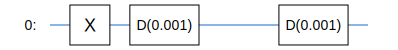

In [30]:
noise_model = cirq.ConstantQubitNoiseModel(cirq.DepolarizingChannel(p=1e-3))
q = cirq.LineQubit(0)
circuit4 = cirq.Circuit(cirq.X(q))
circuit4.append(cirq.Moment())
circuit4 = cirq.Circuit(noise_model.noisy_moments(circuit4.moments, [q]))
print(circuit4)
SVGCircuit(circuit4)

               ┌──┐       ┌──┐
(0, 0): ───@────@─────@────@─────────────────────────
           │    │     │    │
(0, 1): ───X────┼@────X────┼@────────────────────────
                ││         ││
(1, 0): ───@────X┼────@────X┼────────────────────────
           │     │    │     │
(1, 1): ───X─────X────X─────X────────────────────────
               └──┘       └──┘


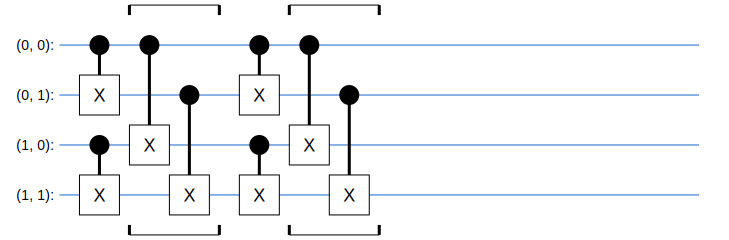

In [31]:
circuit5=cirq.Circuit(
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.Moment(),
    cirq.CNOT(cirq.GridQubit(0,0), cirq.GridQubit(0,1)),
    cirq.CNOT(cirq.GridQubit(1,0), cirq.GridQubit(1,1)),
    cirq.CNOT(cirq.GridQubit(0,0), cirq.GridQubit(1,0)),
    cirq.CNOT(cirq.GridQubit(0,1), cirq.GridQubit(1,1)),
    cirq.Moment(),
    cirq.Moment(),
    cirq.CNOT(cirq.GridQubit(0,0), cirq.GridQubit(0,1)),
    cirq.CNOT(cirq.GridQubit(1,0), cirq.GridQubit(1,1)),
    cirq.CNOT(cirq.GridQubit(0,0), cirq.GridQubit(1,0)),
    cirq.CNOT(cirq.GridQubit(0,1), cirq.GridQubit(1,1)),
)
print(circuit5)
SVGCircuit(circuit5)

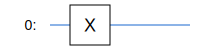

In [32]:
q0 = cirq.LineQubit(0)
SVGCircuit(cirq.Circuit([cirq.Moment([cirq.X(q0)]), cirq.Moment([])]))